In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
from fastai2.data.transforms import get_image_files
from fastai2.vision.all import show_image, show_images
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from htools import *
from img_wang.data import load_img

In [32]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [306]:
# Maybe later add some transform (rotate, affine, noise, etc.) so it's not
# a perfect duplicate. But for now we've had trouble getting even easy tasks
# to work so I think it's a fine place to start.
class PatchworkDS(Dataset):
    
    def __init__(self, dir_=None, paths=(), shape=(128, 128), n=3, 
                 patch_shape=(48, 48), **kwargs):
        if not dir_ and not paths:
            raise ValueError('One of dir_ or paths should be non-null.')
            
        self.paths = paths or get_image_files(dir_)
        self.n = n
        self.load_img = partial(load_img, shape=shape)
        self.shape = shape
        self.patch_h, self.patch_w = patch_shape
        self.max_top = shape[0] - self.patch_h
        self.max_left = shape[1] - self.patch_w
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, i):
        """
        1 if patch is from the original image, 0 otherwise.
        """
        img = self.load_img(self.paths[i])
        src_coords = self.sample_coords()
        if np.random.uniform() > 0.5:
            img2 = torch.tensor(img)
            targ_coords = self.sample_coords()
            y = 1
        else:
            i2 = i
            while i2 == i:
                i2 = np.random.choice(len(self))
            img2 = self.load_img(self.paths[i2])
            targ_coords = src_coords
            y = 0
        
        img[targ_coords] = img2[src_coords]
        return img, torch.tensor(y)
    
    def sample_coords(self):
        left_x = np.random.randint(0, self.max_left)
        top_y = np.random.randint(0, self.max_top)
        return (slice(None), 
                slice(top_y, top_y+self.patch_h), 
                slice(left_x, left_x+self.patch_w))

In [307]:
ds = PatchworkDS('data/imagewang-160/unsup/')

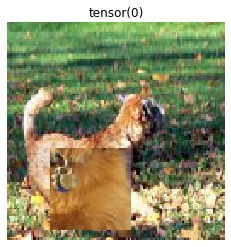

In [309]:
x, y = ds[4]
show_image(x, title=y)

In [310]:
dl = DataLoader(ds, batch_size=4, shuffle=False)

In [311]:
it = iter(dl)
xb, yb = next(it)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


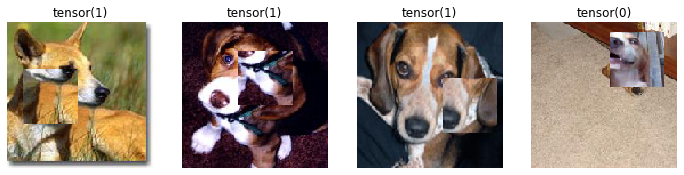

In [312]:
show_images(xb, titles=yb)